# 탐색한 데이터를 바탕으로 모델의 성능 개선하기
- feature engineering 해보기
- 수치의 범위가 너무 넓으면 수치형 변수의 조건이 세분화 되어 tree가 깊어진다 -> 2번 실습 EDA 12.2번 displot 관련
- 샘플의 수가 적으면 오버피팅(과적함)이 발생할 가능성이 높다
- 오버피팅이란? 모의고사에 너무 익숙해져 실전 시험에서 좋은 결과를 얻지 못 하는 현상
- 따라서 수치형 데이터를 범주화하여 성능을 높여볼 수 있다

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [58]:
df = pd.read_csv("diabetes.csv")
df.shape

(768, 9)

In [3]:
# Outcome이 우리가 예측해야할 데이터
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


# Feature Engineering
- ★전처리는 EDA를 먼저 진행해 인사이트를 얻은 후 진행하는 것이 좋다★

## 수치형 변수를 범주형 변수로 만들기

In [59]:
# 임신 횟수가 높은 그룹을 Pregnancies_high 변수로 만들어준다.
df["Pregnancies_high"] = df["Pregnancies"] > 6
df[["Pregnancies", "Pregnancies_high"]]

,Pregnancies,Pregnancies_high
0,6,False
1,1,False
2,8,True
3,1,False
4,0,False
...,...,...
763,10,True
764,2,False
765,5,False
766,1,False


In [60]:
# 나이 범주화 해서 변수에 넣기
# 판다스에서 조건식 사용할 때, and 안 되고 & 써야하고, 소괄호 꼭 써줘야 한다.
# 컬럼을 각각의 컬럼으로 구간마다 만들어 주는 것 = One-Hot-Incoding
# One-Hot-Incoding은 꼭 수치 데이터가 아니더라도, low, middle, high로 되어있더라도 각각의 컬럼으로 만들 수 있다
# One-Hot-Incoding을 할 때는 수치 데이터를 범주화한 후 다시 수치 데이터로 변경 (수치-> 범주-> 수치)

df["Age_low"] = df["Age"] < 25
df["Age_middle"] = (25 <= df["Age"]) & (df["Age"] <= 60) 
df["Age_high"] = df["Age"] > 60
df[["Age", "Age_low", "Age_middle", "Age_high"]].head()

,Age,Age_low,Age_middle,Age_high
0,50,False,True,False
1,31,False,True,False
2,32,False,True,False
3,21,True,False,False
4,33,False,True,False


<AxesSubplot:xlabel='Age_low', ylabel='count'>

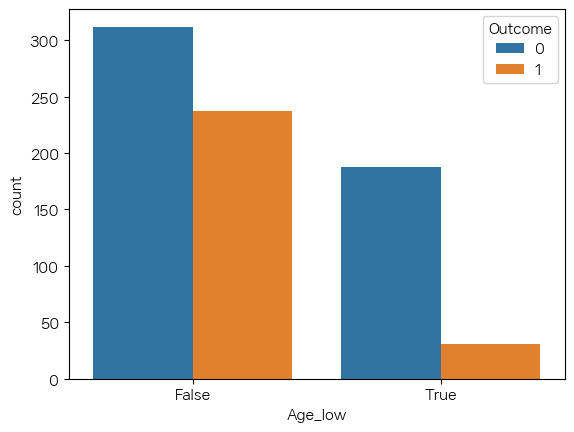

In [6]:
sns.countplot(data=df, x="Age_low", hue="Outcome")

## 결측치 다루기

In [61]:
# 결측치가 없는 것으로 보이지만 0으로 나온 데이터는 결측치로 봐야한다.
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
Pregnancies_high            0
Age_low                     0
Age_middle                  0
Age_high                    0
dtype: int64

In [8]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [62]:
# 인슐린에 0값을 결측치로 변경
df["Insulin_nan"] = df["Insulin"].replace(0, np.nan)
df[["Insulin", "Insulin_nan"]].head()

,Insulin,Insulin_nan
0,0,NaN
1,0,NaN
2,0,NaN
3,94,94.0
4,168,168.0


In [63]:
# 결측치 비율
df["Insulin_nan"].isnull().mean() 

0.4869791666666667

In [64]:
# Insulin과 Insulin_nan의 차이가 많이 나는 것을 알 수 있다
# 결측치가 너무 많으면 학습을 할 때 오류가 발생한다.
df.groupby(["Outcome"])["Insulin", "Insulin_nan"].agg(["mean", "median"])

C:\Users\wldus\AppData\Local\Temp\ipykernel_21228\3599331784.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df.groupby(["Outcome"])["Insulin", "Insulin_nan"].agg(["mean", "median"])


Insulin        Insulin_nan       
               mean median        mean median
Outcome                                      
0         68.792000   39.0  130.287879  102.5
1        100.335821    0.0  206.846154  169.5

In [65]:
# 결측치 채우기
# 인슐린이 0인 값을 위에서 Nan값으로 바꾼 후, 그대로 머신러닝을 돌릴 경우, 오류 발생하며 돌아가지 않는다(fit 과정에서)
# 따라서 결측치를 채워줘야 한다!
# 결측치를 채우는 데에는 평균을 채우는 방법과 중앙값을 채우는 방법이 있다
df.loc[(df["Outcome"] == 1) & (df["Insulin_nan"].isnull()), "Insulin_nan"] = 169.5 # 인슐린의 평균으로 채워주기
df.loc[(df["Outcome"] == 1) & (df["Insulin_nan"].isnull()), "Insulin_nan"] # 결측치 없는 것 확인

Series([], Name: Insulin_nan, dtype: float64)

In [66]:
df.loc[(df["Outcome"] == 0) & (df["Insulin_nan"].isnull()), "Insulin_nan"] = 102.5
df.loc[(df["Outcome"] == 0) & (df["Insulin_nan"].isnull()), "Insulin_nan"] 

Series([], Name: Insulin_nan, dtype: float64)

## 왜도, 첨도
- 데이터가 한 쪽으로 몰려 있으면 학습을 할 때 어려움이 있을 수 있다.
- 왜도: 치우친 정도
- 첨도: 뾰족한 정도
- log 변환을 하면 정규분포와 비슷한 모양을 띈다.
- 0 이하에서는 음의 무한대 값에 수렴하므로 +1을 해준다

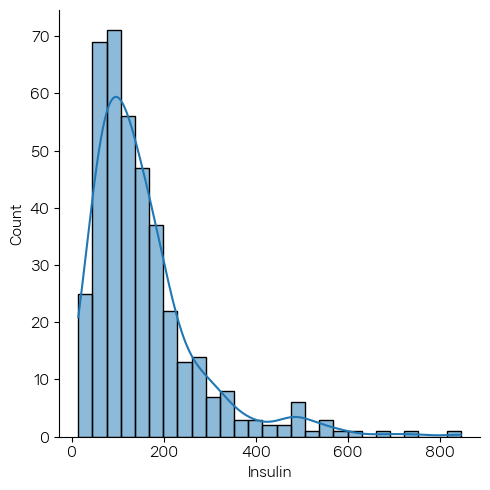

In [67]:
# sns.distplot(df.loc[df["Insulin"] > 0, "Insulin"])
# 한 쪽으로 치우쳐져 있는 것을 볼 수 있다.
sns.displot(df.loc[df["Insulin"] > 0, "Insulin"], kde=True)

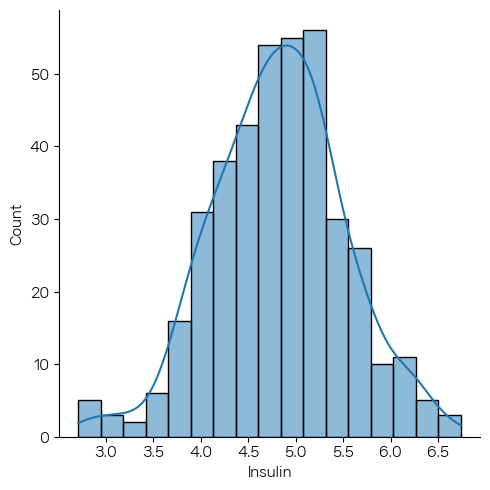

In [68]:
# 로그를 씌워 전처리 하면 정규분포 형태로 표현된다
# 로그를 취할 때는 +1을 보통 해준다 -> 0 이하에서는 음의 값을 수렴하기 때문에
# 한 쪽으로 데이터가 몰려있을 때보다 정규분포 형태여야 머신러닝이 더 좋은 성능을 낸다
sns.displot(np.log(df.loc[df["Insulin"] > 0, "Insulin"] + 1), kde=True)

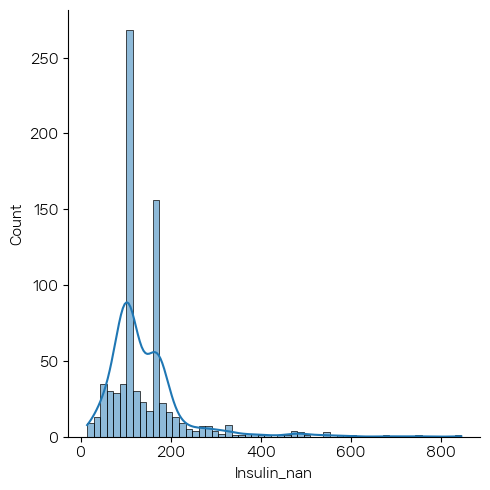

In [69]:
sns.displot(df["Insulin_nan"], kde=True)

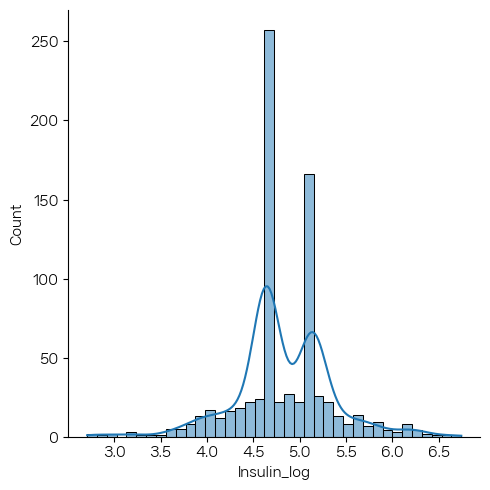

In [70]:
# 인슐린 결측치 그래프 로그 취하기
df["Insulin_log"] = np.log(df["Insulin_nan"] + 1)
sns.displot(df["Insulin_log"], kde=True)

## 파생 변수 만들기
- 지난 EDA 실습에서 Insulin과 Glucose의 상관 관계가 꽤 높아, 이를 파생변수로 만들어 머신러닝에 학습시켜 성능을 보려한다

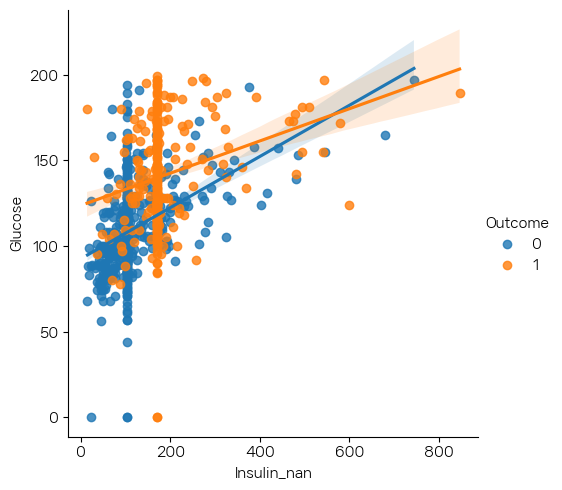

In [71]:
# 중앙값으로 채워준 곳도 보인다
sns.lmplot(data=df, x="Insulin_nan", y="Glucose", hue="Outcome")

In [72]:
# and가 아닌 &을 쓰고, ()로 연산자 우선 순위를 지정해주어야 오류가 나지 않는다
# 인슐린과 글루코스의 상관계수로 파생변수 low_glu_insulin 만들기
df["low_glu_insulin"] = (df["Glucose"] < 100) & (df["Insulin_nan"] <= 102.5)
df["low_glu_insulin"].head()

0    False
1     True
2    False
3     True
4    False
Name: low_glu_insulin, dtype: bool

In [73]:
# crosstab 범주형에 사용
# Outcome과 low_glu_insulin의 관계를 알아보기
# low_glu_insulin이 True인 값의 발병 확률은 매우 낮다.
pd.crosstab(df["Outcome"], df["low_glu_insulin"])

low_glu_insulin,False,True
Outcome,,
0,332,168
1,263,5


## 이상치 다루기

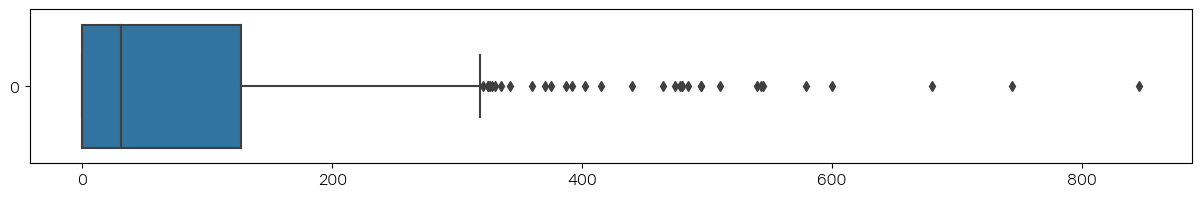

In [74]:
# 인슐린 결측치 처리를 안 한 데이터에서는 박스가 0에 붙어 있다.
plt.figure(figsize=(15,2))
sns.boxplot(data=df["Insulin"], orient="h");

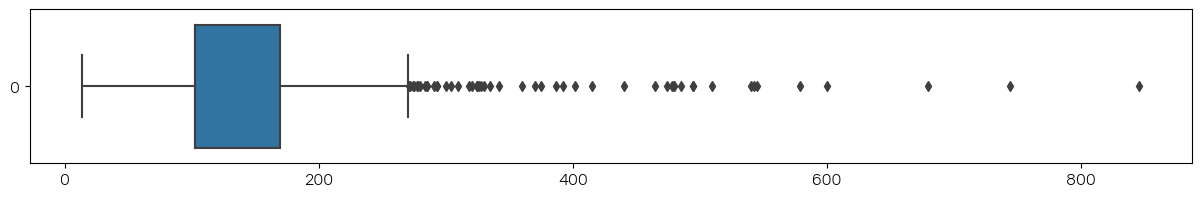

In [75]:
# 결측치 처리한 부분은 0에서 떨어져 있다
plt.figure(figsize=(15,2))
sns.boxplot(data=df["Insulin_nan"], orient="h");

In [76]:
df["Insulin_nan"].describe()

# 상자 시작 부분: 102.5
# nan값을 중앙값으로 채워주었으므로 25%와 50% 값이 같다
# max값이 높기 때문에 평균도 크게 나왔다

count    768.000000
mean     141.753906
std       89.100847
min       14.000000
25%      102.500000
50%      102.500000
75%      169.500000
max      846.000000
Name: Insulin_nan, dtype: float64

In [77]:
# IQR 값 구해주기
IQR3 = df["Insulin_nan"].quantile(0.75)
IQR1 = df["Insulin_nan"].quantile(0.25)
IQR = IQR3 - IQR1
IQR

67.0

In [78]:
OUT = IQR3 + (IQR * 1.5) 
OUT 

270.0

In [79]:
# OUT 바깥 부분 이상치들인데.. 제거하기엔 너무 많다!
df[df["Insulin_nan"] > OUT].shape

(51, 16)

In [80]:
df[df["Insulin_nan"] > 600].shape

# 그럼 밑에 train에서만 600 이상인 이상치값들을 제거해주기로 한다. 
# 미래값은 제거할 수 없기 때문에 

(3, 16)

## Scaling
- 숫자의 범위가 다르면 feature별로 비중이 다르게 계산될 수 있으므로 스케일링 기법을 사용하기도 한다.
- 점수를 후하게 주는 사람, 짜게 주는 사람.. 여기에서 오는 점수 차를 맞추기 위하여
- 숫자의 범위가 크고, 다른 변수들과 범위 차이가 많이 날 경우에 사용해주면 머신러닝의 성능을 높일 수 있다

In [25]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Pregnancies_high,Age_low,Age_middle,Age_high,Insulin_nan,Insulin_log,low_glu_insulin
0,6,148,72,35,0,33.6,0.627,50,1,False,False,True,False,169.5,5.138735,False
1,1,85,66,29,0,26.6,0.351,31,0,False,False,True,False,102.5,4.639572,True
2,8,183,64,0,0,23.3,0.672,32,1,True,False,True,False,169.5,5.138735,False
3,1,89,66,23,94,28.1,0.167,21,0,False,True,False,False,94.0,4.553877,True
4,0,137,40,35,168,43.1,2.288,33,1,False,False,True,False,168.0,5.129899,False


In [27]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(df[["Glucose", "DiabetesPedigreeFunction"]])
scale = scaler.transform(df[["Glucose", "DiabetesPedigreeFunction"]])
scale

# Glucose와 DiabetesPedigreeFunction

array([[ 0.84832379,  0.46849198],
       [-1.12339636, -0.36506078],
       [ 1.94372388,  0.60439732],
       ...,
       [ 0.00330087, -0.68519336],
       [ 0.1597866 , -0.37110101],
       [-0.8730192 , -0.47378505]])

In [29]:
# 값이 잘 들어갔는지 확인
df[["Glucose", "DiabetesPedigreeFunction"]] = scale
df[["Glucose", "DiabetesPedigreeFunction"]].head()

,Glucose,DiabetesPedigreeFunction
0,0.848324,0.468492
1,-1.123396,-0.365061
2,1.943724,0.604397
3,-0.998208,-0.920763
4,0.504055,5.484909


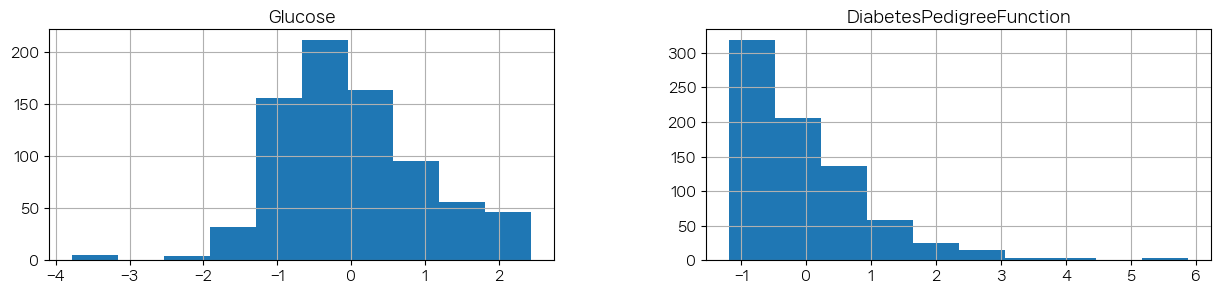

In [31]:
# Glucose와 DiabetesPedigreeFunction의 범위가 처음에는 차이가 많이 났었지만 지금은 차이가 줄어듦 (x축 범위)
h = df[["Glucose", "DiabetesPedigreeFunction"]].hist(figsize=(15,3))

# csv 파일로 저장하기
- 전저리할 때 scaling 단계는 별로 크게 성능이 올라가지 않았기 때문에 scaling 과정 전까지 실행 후, csv 파일을 저장하여 다음 실습에 사용하기로 한다!

In [84]:
df.to_csv("diabetes_feature.csv", index=False)

In [85]:
pd.read_csv("diabetes_feature.csv")

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Pregnancies_high,Age_low,Age_middle,Age_high,Insulin_nan,Insulin_log,low_glu_insulin
0,6,148,72,35,0,33.6,0.627,50,1,False,False,True,False,169.5,5.138735,False
1,1,85,66,29,0,26.6,0.351,31,0,False,False,True,False,102.5,4.639572,True
2,8,183,64,0,0,23.3,0.672,32,1,True,False,True,False,169.5,5.138735,False
3,1,89,66,23,94,28.1,0.167,21,0,False,True,False,False,94.0,4.553877,True
4,0,137,40,35,168,43.1,2.288,33,1,False,False,True,False,168.0,5.129899,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0,True,False,False,True,180.0,5.198497,False
764,2,122,70,27,0,36.8,0.340,27,0,False,False,True,False,102.5,4.639572,False
765,5,121,72,23,112,26.2,0.245,30,0,False,False,True,False,112.0,4.727388,False
766,1,126,60,0,0,30.1,0.349,47,1,False,False,True,False,169.5,5.138735,False


# 학습, 예측 데이터셋 나누기

In [32]:
# 8:2 비율로 구하기 위해 전체 데이터 행에서 80% 위치에 해당되는 값을 구한다
split_count = int(df.shape[0] * 0.8)
split_count

614

In [33]:
# train, test 데이터 나누기
# 깊은 복사
train = df[:split_count].copy()
train.shape

(614, 16)

In [34]:
# 이상치를 제거할 경우
# train에서만 600 이상인 이상치값들을 제거해주기로 한다. 
# 미래값은 제거할 수 없기 때문에 
train = train[train["Insulin_nan"] < 600]
train.shape

(610, 16)

In [35]:
test = df[split_count:].copy()
test.shape

(154, 16)

# 학습, 예측에 사용할 컬럼

In [36]:
# 학습에 필요한 컬럼 제외 나머지 삭제하기
feature_names = train.columns.tolist()
feature_names.remove("Pregnancies")
feature_names.remove("Outcome")
feature_names.remove("Age_low")
feature_names.remove("Age_middle")
feature_names.remove("Age_high")
feature_names.remove('Insulin')
feature_names.remove('Insulin_log')
feature_names

['Glucose',
 'BloodPressure',
 'SkinThickness',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age',
 'Pregnancies_high',
 'Insulin_nan',
 'low_glu_insulin']

# 정답값이자 예측해야될 값

In [37]:
# feature_names는 여러 값을 갖고 있으므로 리스트로 만들어주었고, label_name은 값이 하나이므로 리스트로 만들지 않았다!
label_name = "Outcome"
label_name

'Outcome'

# 학습, 예측 데이터셋 만들기

In [38]:
# 학습 세트 만들기 (예) 시험의 기출 문제
X_train = train[feature_names]
print(X_train.shape)
X_train.head()

(610, 9)


,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age,Pregnancies_high,Insulin_nan,low_glu_insulin
0,0.848324,72,35,33.6,0.468492,50,False,169.5,False
1,-1.123396,66,29,26.6,-0.365061,31,False,102.5,True
2,1.943724,64,0,23.3,0.604397,32,True,169.5,False
3,-0.998208,66,23,28.1,-0.920763,21,False,94.0,True
4,0.504055,40,35,43.1,5.484909,33,False,168.0,False


In [39]:
# 정답 만들기 (예) 기출 문제의 정답
y_train = train[label_name]
print(y_train.shape)
y_train.head()

# 이때 정답과 문제의 행의 개수가 똑같아야 한다! (614개)
# 문제는 대문자 X, 정답은 소문자 y
# X는 행렬로 구성, y는 벡터로 구성

(610,)


0    1
1    0
2    1
3    0
4    1
Name: Outcome, dtype: int64

In [40]:
# 예측에 사용할 데이터셋 만들기 (예) 실전 시험 문제
X_test = test[feature_names]
print(X_test.shape)
X_test.head()

# 실제 시험 문제에서도 기출 문제와 컬럼 개수가 똑같아야 한다! (8개)

(154, 9)


,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age,Pregnancies_high,Insulin_nan,low_glu_insulin
614,0.535352,74,26,36.1,0.257084,50,True,144.0,False
615,-0.466156,72,0,25.8,-0.799958,27,False,102.5,False
616,-0.121888,96,0,28.7,-0.950964,30,False,102.5,False
617,-1.655448,62,13,20.1,-0.648952,23,False,15.0,True
618,-0.278373,82,24,28.2,2.446670,50,True,169.5,False


In [41]:
# 예측의 정답값 (예) 실전 시험 문제의 정답
y_test = test[label_name]
print(y_test.shape)
y_test.head()

(154,)


614    1
615    0
616    0
617    0
618    1
Name: Outcome, dtype: int64

# 머신러닝 알고리즘 가져오기

In [42]:
# 분류 문제이니 Classifier로!
from sklearn.tree import DecisionTreeClassifier 

model = DecisionTreeClassifier()
model

# 스무고개와도 같은 알고리즘이다.
# 질문에 꼬리에 꼬리를 물고 내려가면서.. 당뇨병인지 아닌지 여부를 판단한다.

DecisionTreeClassifier()

# 학습(훈련)

In [43]:
# 시험을 볼 때 기출 문제(X_train)와 정답(y_train)을 보고 공부하는 과정이라 생각하면 된다.
# 모델에 기출 문제와 정답을 넣어주면 알아서 학습한다
model.fit(X_train, y_train)

DecisionTreeClassifier()

# 예측

In [44]:
# 실전 시험 문제(X_test)라고 생각하면 된다. 우리가 정답을 직접 예측한다
# X만 넣어주고 정답을 따로 넣어주지는 않는다.
# 실제로 시험장 가서도 정답이 따로 없잖아? 그것마냥
y_predict = model.predict(X_test)
y_predict

array([1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0],
      dtype=int64)

# 트리 알고리즘 분석하기
- 의사결정나무 시각화

[Text(0.5481770833333334, 0.9615384615384616, 'Insulin_nan <= 143.5\ngini = 0.453\nsamples = 610\nvalue = [399, 211]'),
 Text(0.3298611111111111, 0.8846153846153846, 'Insulin_nan <= 109.0\ngini = 0.163\nsamples = 380\nvalue = [346, 34]'),
 Text(0.25, 0.8076923076923077, 'BMI <= 49.95\ngini = 0.098\nsamples = 329\nvalue = [312, 17]'),
 Text(0.2361111111111111, 0.7307692307692307, 'Glucose <= 0.958\ngini = 0.082\nsamples = 326\nvalue = [312, 14]'),
 Text(0.2013888888888889, 0.6538461538461539, 'Insulin_nan <= 99.5\ngini = 0.062\nsamples = 312\nvalue = [302, 10]'),
 Text(0.1875, 0.5769230769230769, 'Insulin_nan <= 95.5\ngini = 0.154\nsamples = 119\nvalue = [109, 10]'),
 Text(0.1736111111111111, 0.5, 'BloodPressure <= 83.0\ngini = 0.127\nsamples = 117\nvalue = [109, 8]'),
 Text(0.1111111111111111, 0.4230769230769231, 'DiabetesPedigreeFunction <= 0.621\ngini = 0.088\nsamples = 108\nvalue = [103, 5]'),
 Text(0.05555555555555555, 0.34615384615384615, 'SkinThickness <= 31.5\ngini = 0.044\nsamp

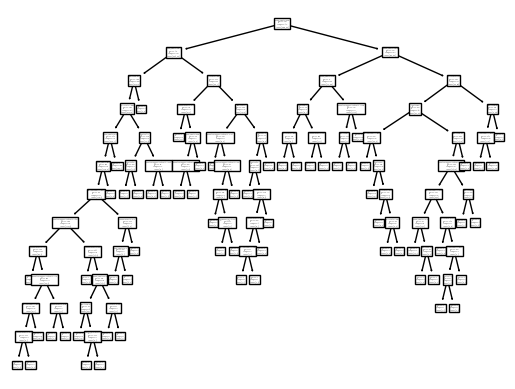

In [45]:
from sklearn.tree import plot_tree

# 텍스트로 tree가 나온다
plot_tree(model, feature_names=feature_names)

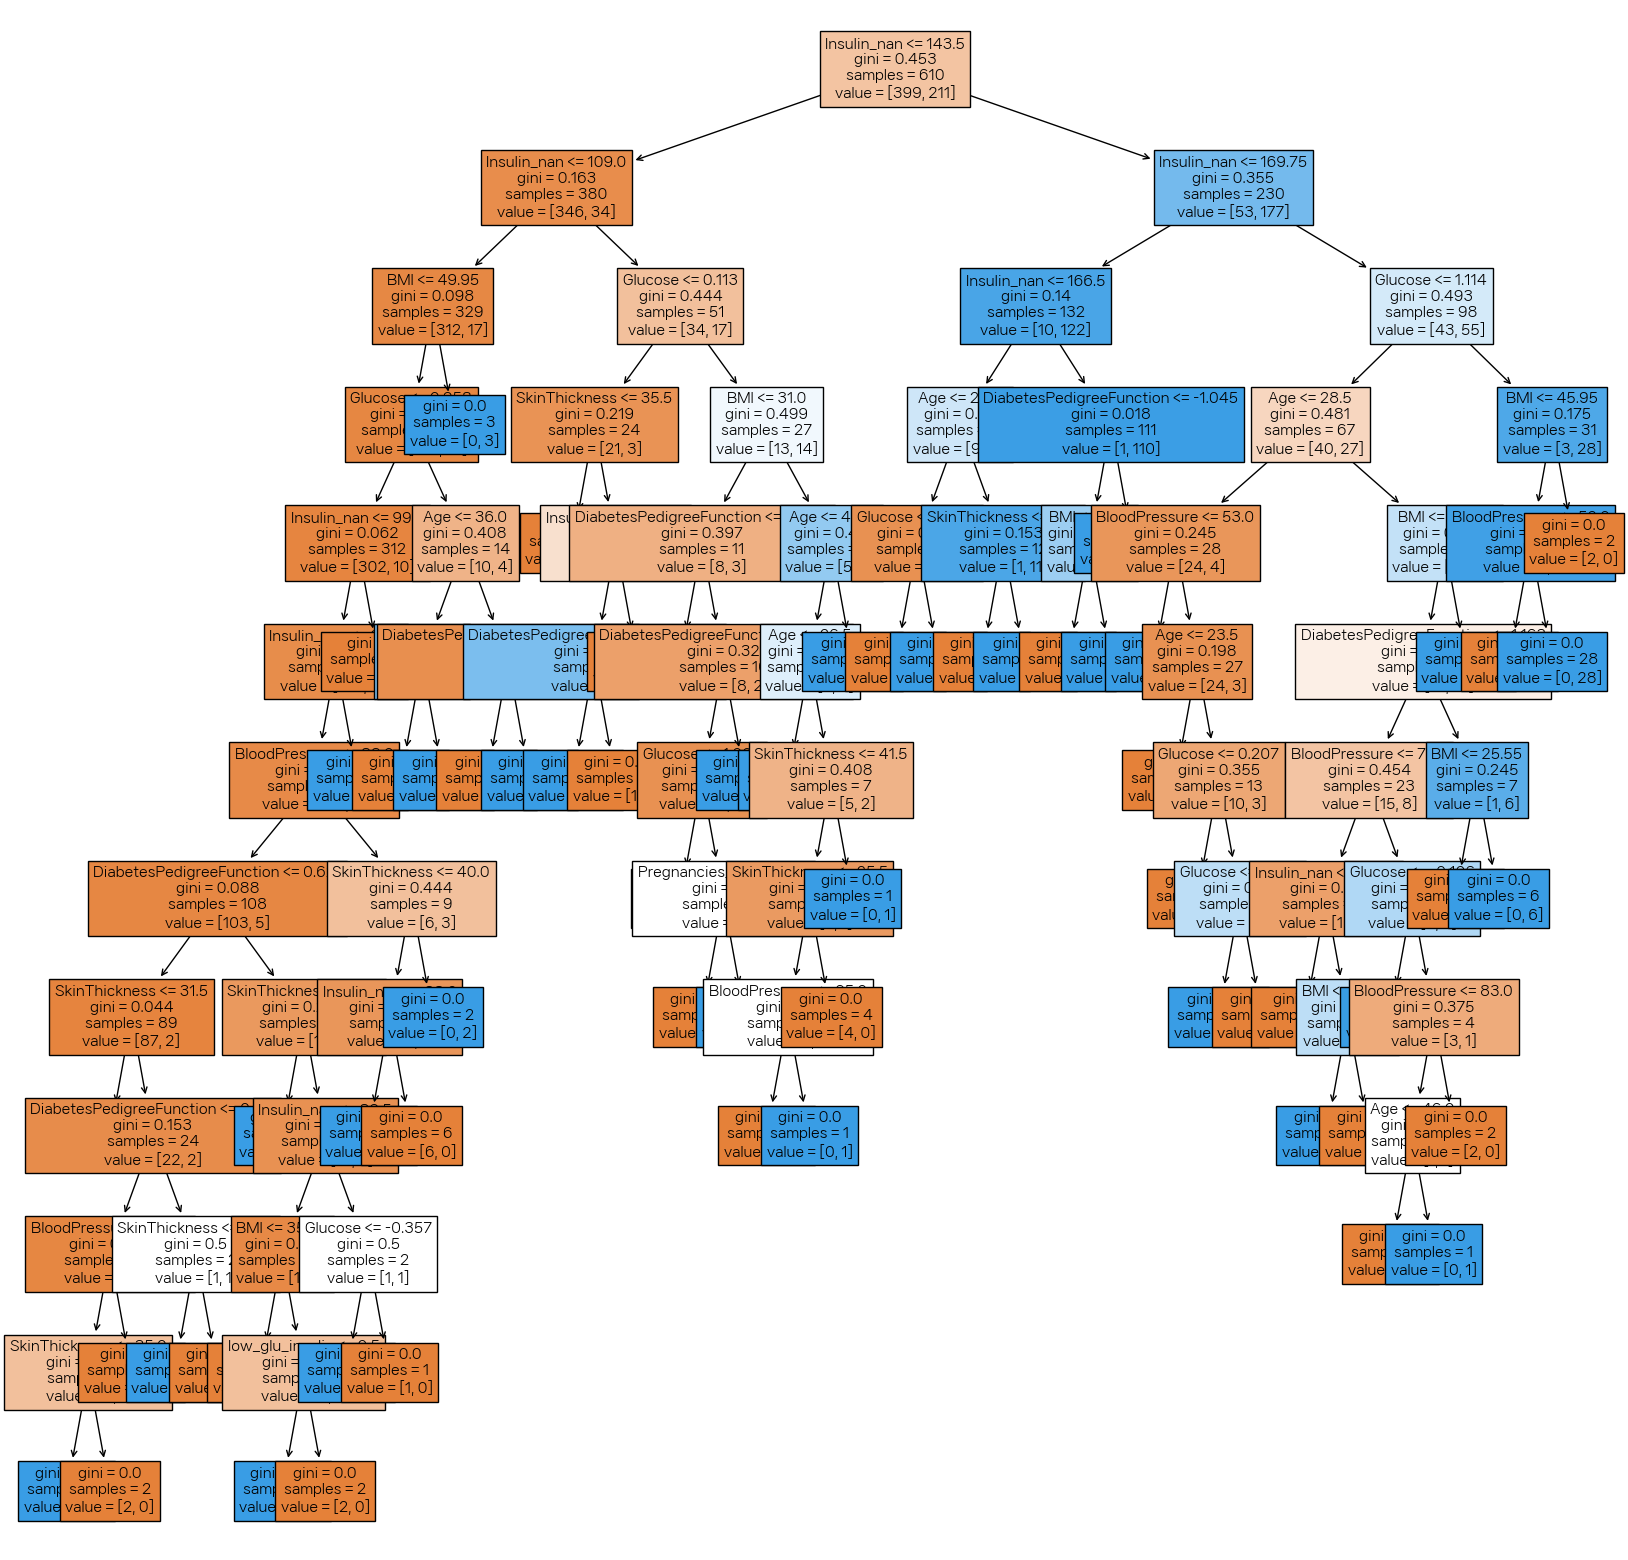

In [46]:
plt.figure(figsize=(20,20))
tree = plot_tree(model, feature_names=feature_names,
                filled=True, fontsize=10)

In [47]:
# 피처의 중요도 추출하기
# 우리가 지정한 피처의 순서에 따른 중요도 
model.feature_importances_

array([0.09668371, 0.03182388, 0.04300799, 0.07645751, 0.03858515,
       0.08272508, 0.0036228 , 0.62226348, 0.0048304 ])

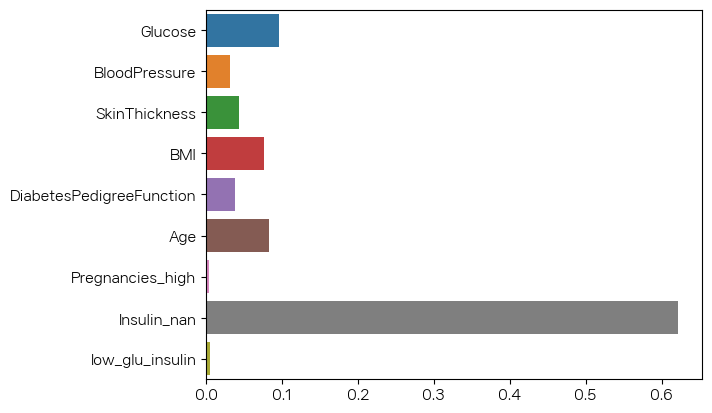

In [48]:
# 피처 중요도 시각화
sns.barplot(x=model.feature_importances_, y=feature_names);

# 정확도 측정하기

In [54]:
# 실제값 - 예측값을 하면 같은 값은 0으로 나올 것이다.
# 여기에서 절대값을 씌운 값이 1인 값이 다르게 예측한 값이 된다.
abs(y_test - y_predict).sum() / len(y_test) # 잘못 예측한 비율

diff_count = abs(y_test - y_predict).sum() # 잘못 예측한 값(전체 틀린 개수 )
diff_count
# 1-잘못 예측한 값 =  우리가 잘 예측한 값

# 0) 1번 실습(처음) => 44
# 1) Pregnancies 범주화 => 39
# 2) Age 범주화 => 50
# 3) 인슐린 결측치를 평균으로 대체 => 24
# 4) 인슐린 결측치를 중앙값으로 대체 => 17
# 5) 인슐린 로그 취해서 로그값 넣기 => 19
# 6) 파생 변수 만들어 주기(low_glu_insulin) - 인슐린과 글루코스 상관 계수 => 18
# 7) 이상치 다루기(인슐린 수치 600 이상 이상치 제거) => 20
# 8) scaling => 18

18

In [55]:
# 예측의 정확도 구하기 (100점 만 점 중 몇 점?)
(len(y_test) - diff_count) / (len(y_test)) * 100 

# 0) 1번 실습(처음)
# 1) Pregnancies 범주화
# 2) Age를 low, middle, high 범주화
# 3) 인슐린 결측치를 평균으로 대체 => 84 
# 4) 인슐린 결측치를 중앙값으로 대체 => 88%
# 5) 인슐린 로그 취해서 로그값 넣기 => 87%
# 6) 파생 변수 만들어 주기(low_glu_insulin) - 인슐린과 글루코스 상관 계수 => 88%
# 7) 이상치 다루기(인슐린 수치 600 이상 이상치 제거)
# 8) scaling

88.31168831168831

In [56]:
# 위에처럼 직접 구할 수도 있지만, 미리 구현된 알고리즘을 가져와 사용할 수도 있다
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_predict) * 100

88.31168831168831

In [57]:
# model의 score로 점수를 계산하기
# 정답값을 알고 있을 때 사용 가능(y_test)
model.score(X_test, y_test) * 100

88.31168831168831

<정리>
- 제일 처음 전처리 하지 않고 머신러닝을 돌렸을 때 전체 틀린 개수는 44개
- Pregnancies를 Pregnancies_high를 만들어 범주화한 후 머신러닝을 돌렸을 때 틀린 개수는 39 (컬럼 2개)
- Age를 low, middle, high로 범주화한 후 머신러닝을 돌리니 오히려 틀린 개수가 50개로 늘었고, 성능이 더 떨어졌다. (컬럼 3개) 
- 이것을 One-Hot-Incoding 이라고 한다. One-Hot-Incoding은 범주형 데이터를 수치형 데이터로 변경할 때 많이 사용한다
- 이렇게 범주화하는 것은 성능을 올릴 수도 있지만 내려갈 수도 있다!
- 직접 적용해보며 분석하며 모델 성능을 높여야 함
- Age를 세분화한 것은 지우고(오류가 더 심해졌으니), 인슐린 결측치(인슐린의 평균 or 결측치 평균 ?)를 채운 후 머신러닝을 돌려보니, 중요 요소(feature)는 인슐린으로 변경되었고, 전체 틀린 개수가 23개로 크게 떨어졌다. 성능이 더 좋아졌다는 뜻!
- 인슐린 결측치를 중앙값으로 대체했더니 평균으로 대체했던 값보다 더 좋아졌다 !
- 인슐린 수치를 나이 또는 발병 여부에 맞춰 채워넣을 수도 있다. 결측치를 제거할 수도 있지만 결측치가 너무 많을 경우에서는 채워주는 것이 좋다.
- 인슐린에 로그를 취한 후에 값을 넣어 머신러닝 성능을 올릴 수도 있다. 여기서는 아주 조금 떨어졌지만 좋은 방법이다
- 파생 변수 만들어 주기(low_glu_insulin) - 인슐린과 글루코스 상관 계수를 사용하여 머신러닝을 돌려주었더니 정확도가 아주 조금 더 올라갔다. 인슐린과 글루코스의 상관 계수가 워낙 높아서 이를 파생 변수로 만들어서 넣어주었음.
- 그 다음은 인슐린 수치 이상치를 제거하여 머신러닝을 돌려보았다. 성능이 약간 줄어듦.. 아주 약간. 이 이상치를 500으로 줄일 수도 있고, 값을 바꿀 수도 있다.
- scaling 하여 머신러닝 성능 높여보기. 범위의 차이가 많이나는 변수들을 scaling 해준 후 머신러닝 돌려본다
- 신호와 소음을 찾는 과정이 중요하다 !
- 모든 전처리가 성능을 올려주지 않는다. 꼭 EDA를 해본 후, 내가 여기서 찾아볼 수 있는 게 무엇인지 인사이트를 얻어낼 수 있을지 확인한 후 EDA결과를 Feature Enginerring에 적용한다.
- 좋은 성능을 내지 못 한다면 왜 못 하는지도 분석해볼 것!